In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv
/kaggle/input/global-weather-repository/state.db


1.Basic Assessment

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load Dataset (Kaggle path)
data = pd.read_csv('/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv')  # update if your file name is different
print("Dataset Loaded Successfully!")
print(data.head())


Dataset Loaded Successfully!
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1          

**1.Data cleaning and preprocessing**

In [4]:
print(data.columns)


Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


In [5]:
# Handle missing values properly
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].mean())

print("\nMissing Values After Filling:")
print(data.isnull().sum())

# Removing outliers (IQR Method) on temperature_celsius and precip_mm
for col in ['temperature_celsius', 'precip_mm']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

print("\nShape after removing outliers:", data.shape)

# Normalize 'temperature_celsius' and 'precip_mm'
scaler = MinMaxScaler()
data[['temperature_celsius', 'precip_mm']] = scaler.fit_transform(data[['temperature_celsius', 'precip_mm']])

print("\nNormalized Temperature and Precipitation:")


Missing Values After Filling:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone

**2.Exploratory Data Analysis**## 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


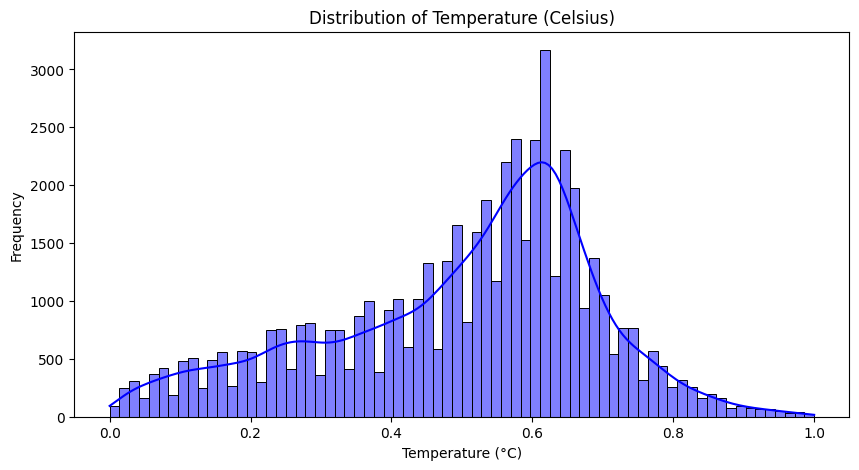

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


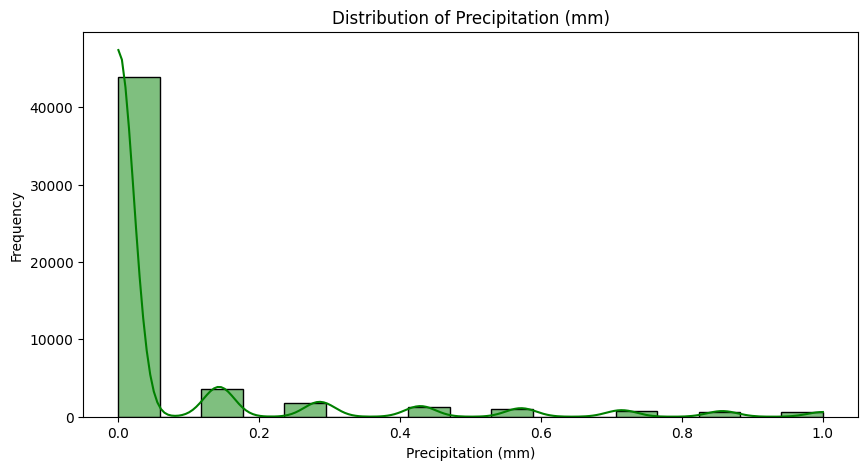

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


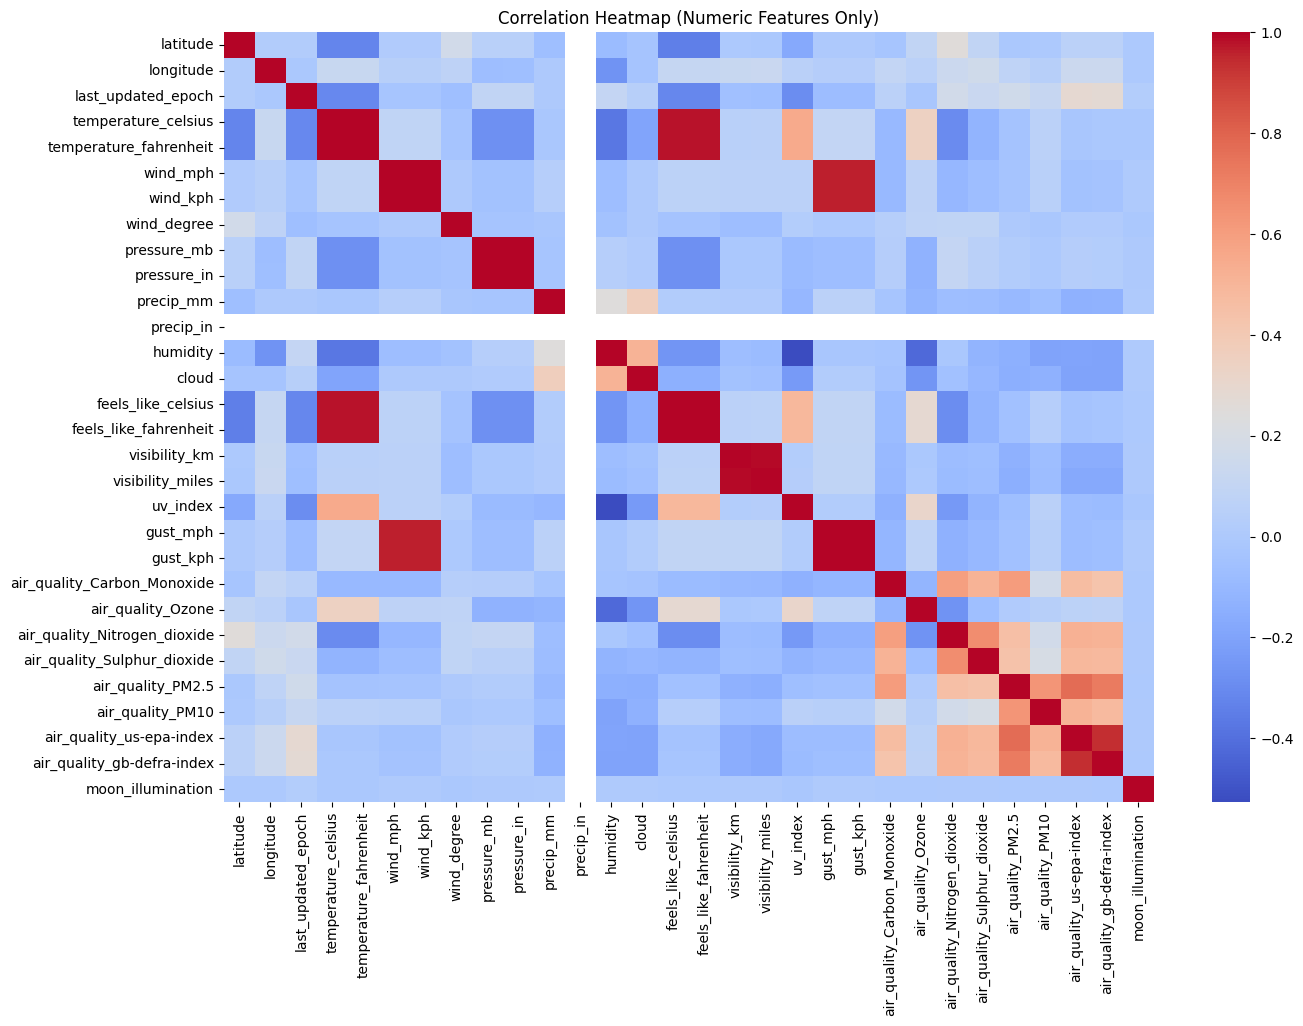

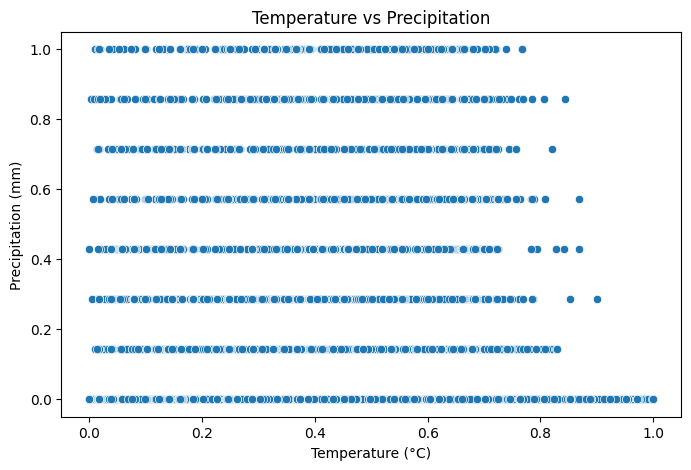

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Temperature Distribution
plt.figure(figsize=(10,5))
sns.histplot(data['temperature_celsius'], kde=True, color='blue')
plt.title('Distribution of Temperature (Celsius)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

# Precipitation Distribution
plt.figure(figsize=(10,5))
sns.histplot(data['precip_mm'], kde=True, color='green')
plt.title('Distribution of Precipitation (mm)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap (only for numeric columns)
plt.figure(figsize=(15,10))
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()

# Scatter Plot: Temperature vs Precipitation
plt.figure(figsize=(8,5))
sns.scatterplot(x='temperature_celsius', y='precip_mm', data=data)
plt.title('Temperature vs Precipitation')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.show()


**3.Model Building**### 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_31/4087512189.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(start=location_data.index[-1], periods=30, freq='H'), forecast, label='Forecast', color='red

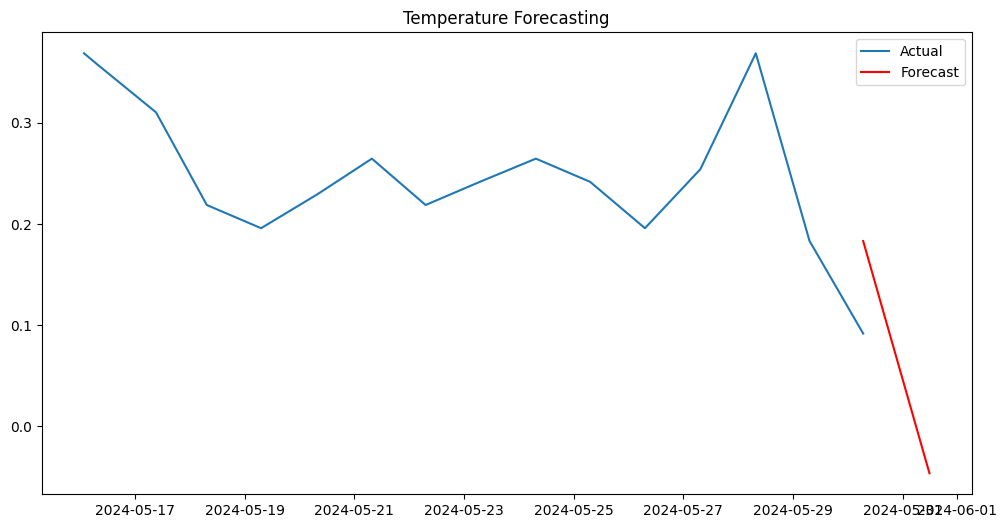


Model Evaluation Metrics:
MAE: 0.0466
MSE: 0.0038
RMSE: 0.0615
R2 Score: 0.2603


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

# For forecasting, we use 'last_updated' as time and temperature_celsius as value
# Convert 'last_updated' to datetime
data['last_updated'] = pd.to_datetime(data['last_updated'])

# Sort by time
data = data.sort_values('last_updated')

# Basic Time Series Forecasting (Exponential Smoothing)
# Use a subset for demonstration (e.g., one location/country)
location_data = data[data['location_name'] == data['location_name'].unique()[0]]

# Setting index to last_updated
location_data.set_index('last_updated', inplace=True)

# Simple Exponential Smoothing on temperature
model = ExponentialSmoothing(location_data['temperature_celsius'], trend='add', seasonal=None)
model_fit = model.fit()

# Forecast next 30 steps
forecast = model_fit.forecast(steps=30)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(location_data.index, location_data['temperature_celsius'], label='Actual')
plt.plot(pd.date_range(start=location_data.index[-1], periods=30, freq='H'), forecast, label='Forecast', color='red')
plt.title('Temperature Forecasting')
plt.legend()
plt.show()

# Evaluate Model on Training Data
predictions = model_fit.fittedvalues

mae = mean_absolute_error(location_data['temperature_celsius'], predictions)
mse = mean_squared_error(location_data['temperature_celsius'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(location_data['temperature_celsius'], predictions)

print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# **2.Advance Assessment** 

1.Advanced EDA

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

from scipy import stats


In [11]:
# Z-score method to detect outliers
def detect_outliers_zscore(df, column):
    threshold = 3
    z = np.abs(stats.zscore(df[column].dropna()))
    outliers = df[column][z > threshold]
    return outliers

# Detect anomalies in temperature and precipitation
temperature_outliers = detect_outliers_zscore(data, 'temperature_celsius')
precipitation_outliers = detect_outliers_zscore(data, 'precip_mm')

print(f"Temperature outliers:\n{temperature_outliers}\n")
print(f"Precipitation outliers:\n{precipitation_outliers}\n")


Temperature outliers:
Series([], Name: temperature_celsius, dtype: float64)

Precipitation outliers:
134      0.857143
67       0.857143
190      0.714286
146      0.857143
158      0.857143
           ...   
66658    1.000000
66724    0.857143
66875    0.714286
66869    0.857143
66957    1.000000
Name: precip_mm, Length: 2022, dtype: float64



**2.Forcasting with multiple models**

In [12]:
# Simple numeric features for model
features = ['humidity', 'pressure_mb', 'wind_kph', 'cloud', 'precip_mm', 'feels_like_celsius', 'uv_index', 'air_quality_Carbon_Monoxide']
target = 'temperature_celsius'

# Drop NaNs
model_data = data[features + [target]].dropna()

X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Model 2: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Model 3: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)


In [16]:
#Evaluate models
def evaluate_model(true, preds, model_name):
    mse = mean_squared_error(true, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, preds)
    print(f"{model_name} -> RMSE: {rmse:.2f}, R2: {r2:.2f}")

evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, gb_preds, "Gradient Boosting")


Linear Regression -> RMSE: 0.03, R2: 0.97
Random Forest -> RMSE: 0.01, R2: 1.00
Gradient Boosting -> RMSE: 0.01, R2: 1.00


In [17]:
# Voting Regressor (Ensemble)
ensemble = VotingRegressor(estimators=[('lr', lr), ('rf', rf), ('gb', gb)])
ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)

evaluate_model(y_test, ensemble_preds, "Ensemble Model")


Ensemble Model -> RMSE: 0.02, R2: 0.99


**3.Unique Analyses**

/tmp/ipykernel_31/2045559882.py:12: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31/2045559882.py:12: UserWarning: Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


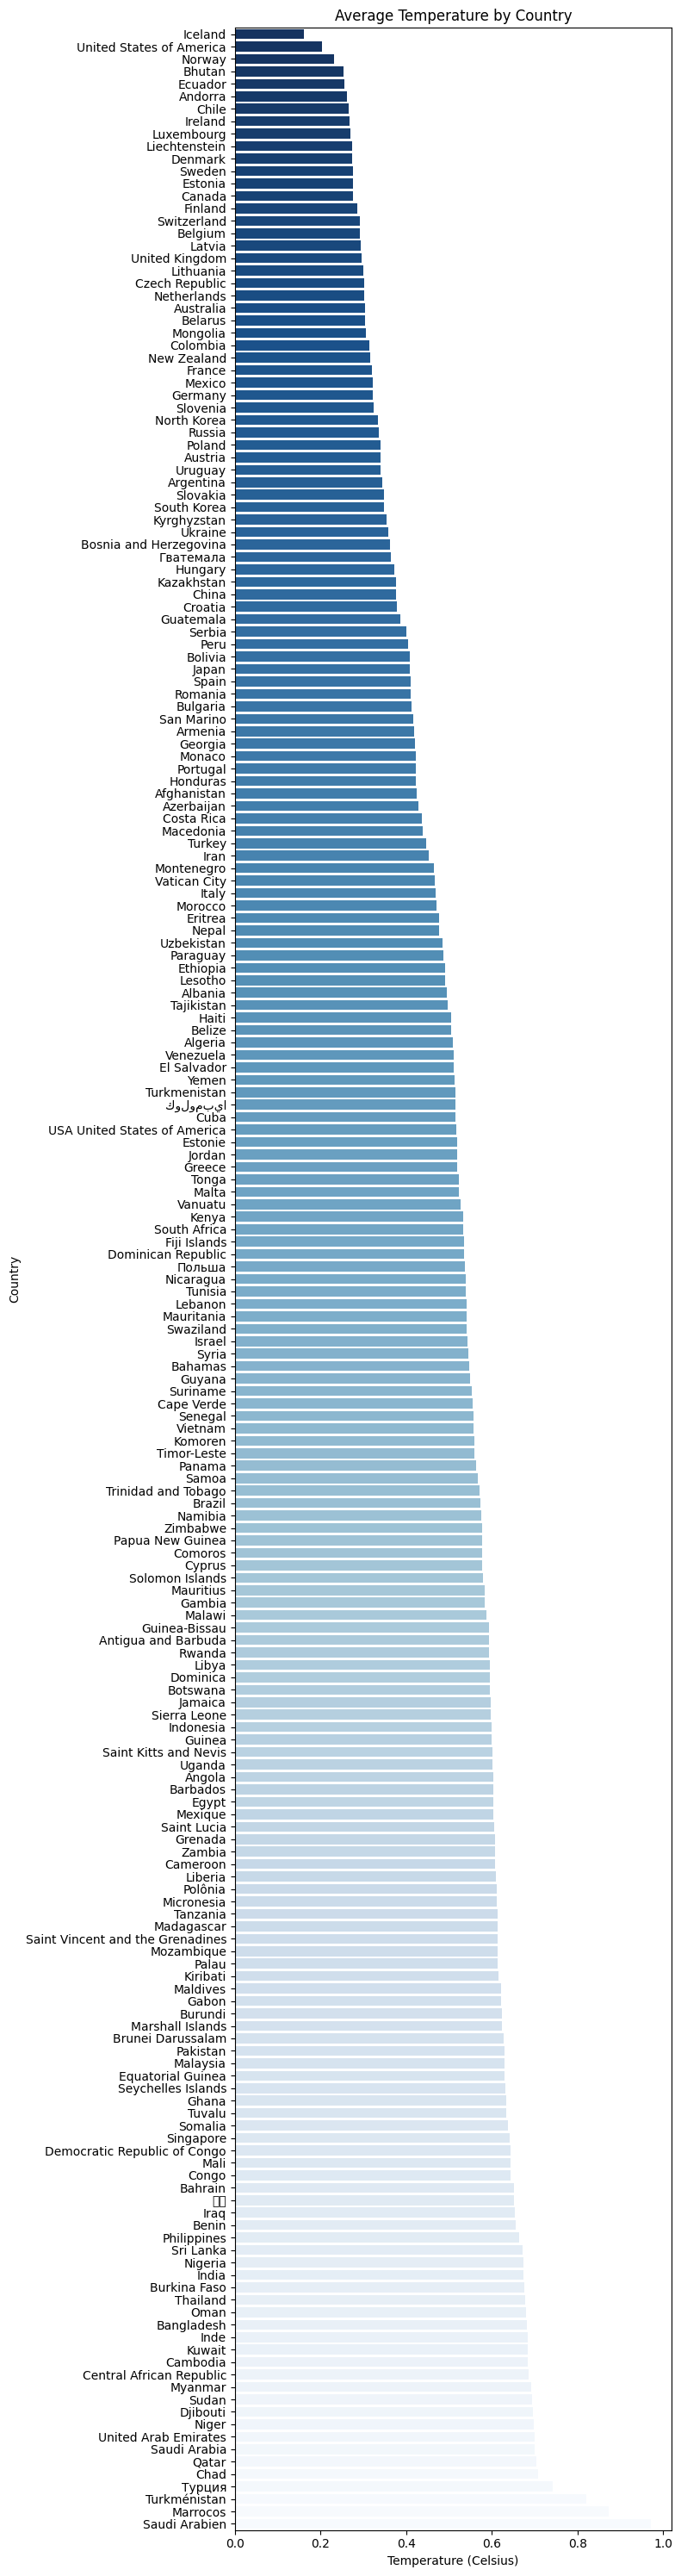

In [25]:
 #Climate Analysis (Long-term Patterns)
# Group by country and calculate mean temperature
country_temp = data.groupby('country')['temperature_celsius'].mean().sort_values()

# Plot
plt.figure(figsize=(8, 30))  # Wider and taller
sns.barplot(x=country_temp.values, y=country_temp.index, palette='Blues_r')

plt.title('Average Temperature by Country')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Country')

plt.tight_layout()
plt.show()


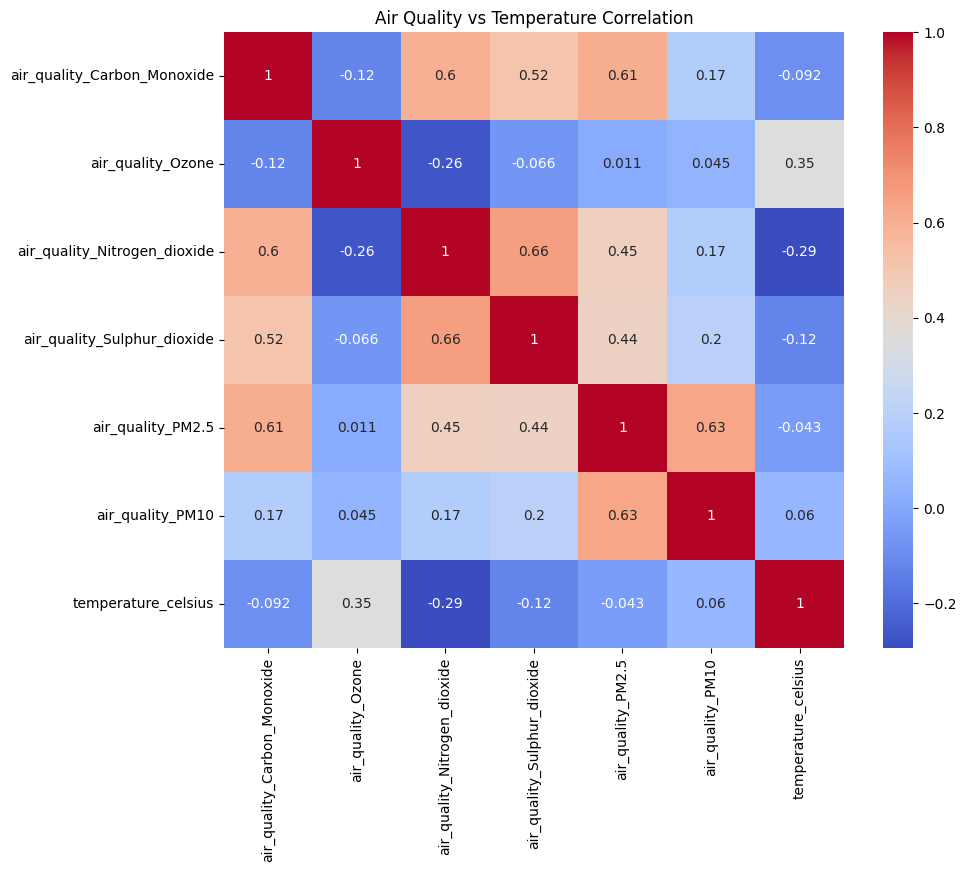

In [23]:
#Environmental Impact: Air Quality Correlation
air_quality_features = [
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10'
]

# Correlation with temperature
air_quality_corr = data[air_quality_features + ['temperature_celsius']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(air_quality_corr, annot=True, cmap='coolwarm')
plt.title('Air Quality vs Temperature Correlation')
plt.show()


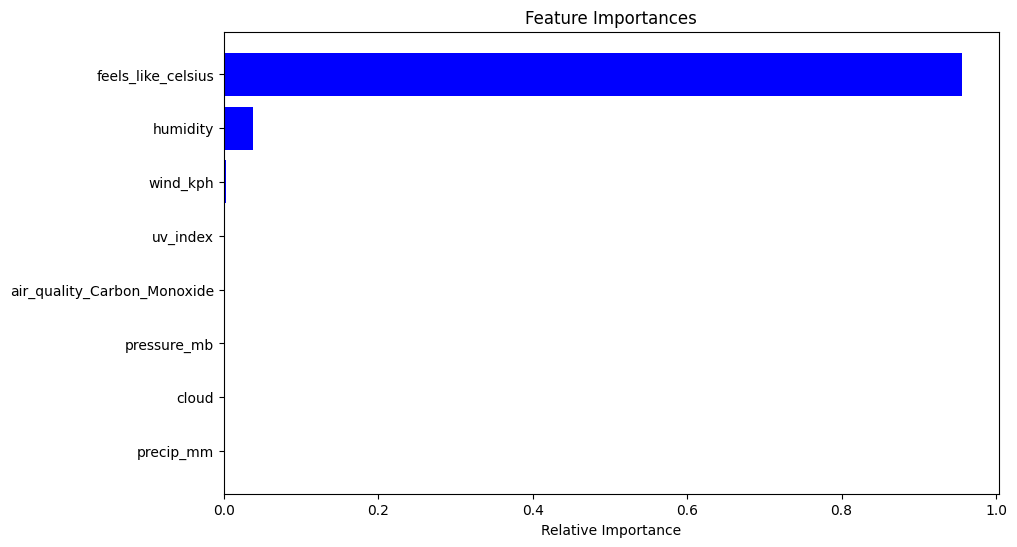

In [24]:
# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [34]:
import plotly.express as px

# If the dataset is large, sample it to reduce the number of points for quicker rendering
data_sampled = data.sample(1000)  # Change 1000 to the number of points you'd like to plot

# Create the scatter geo plot
fig = px.scatter_geo(data_sampled, 
                     lat='latitude', 
                     lon='longitude', 
                     color='temperature_celsius',
                     hover_name='location_name',
                     size='temperature_celsius',
                     projection="natural earth",
                     title="Global Temperature Distribution")

# Show the plot
fig.show()


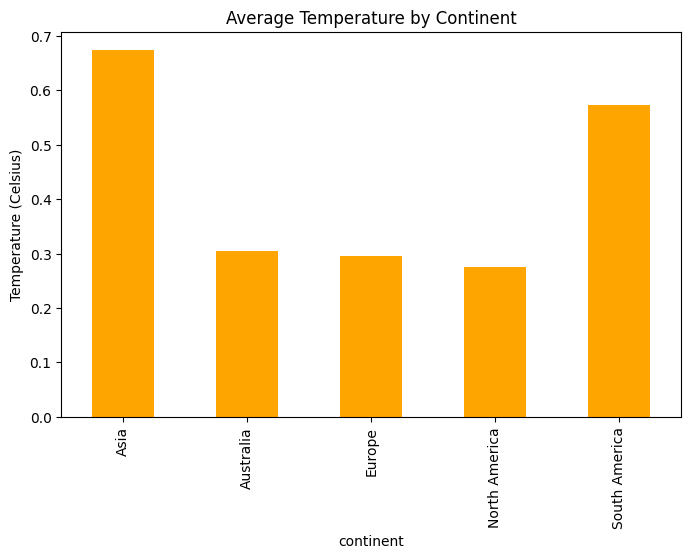

In [35]:
#Geographical Patterns: Weather by Continent

# Basic manual mapping (for demo)
continent_mapping = {
    'United States': 'North America', 'India': 'Asia', 'Australia': 'Australia',
    'Brazil': 'South America', 'United Kingdom': 'Europe', 'Canada': 'North America'
}

data['continent'] = data['country'].map(continent_mapping)

# Average temperature per continent
continent_temp = data.groupby('continent')['temperature_celsius'].mean()

plt.figure(figsize=(8,5))
continent_temp.plot(kind='bar', color='orange')
plt.title('Average Temperature by Continent')
plt.ylabel('Temperature (Celsius)')
plt.show()
